In [1]:
from sqlalchemy import create_engine, text
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
DATABASE_USERNAME = 'lucas'
DATABASE_PASSWORD = 'kappa123test'
DATABASE_IP = '167.88.33.95'
DATABASE_PORT = 5432

In [3]:
engine = create_engine(f'postgresql+psycopg2://{DATABASE_USERNAME}:{DATABASE_PASSWORD}@{DATABASE_IP}:{DATABASE_PORT}/screening_cvm')

In [4]:
def run_query(query):
    with engine.begin() as conn:
        result = conn.execute(query)
        return result.mappings().all()

In [5]:
query_numero_fundos_com_cota = text("""
    SELECT COUNT(*) FROM (SELECT DISTINCT cnpj_fundo_classe, id_subclasse, tp_fundo_classe FROM informacao_diaria) AS sub
""")

# rank de aportes, resgates, numero de cotistas e rentabilidade nos intervalos:

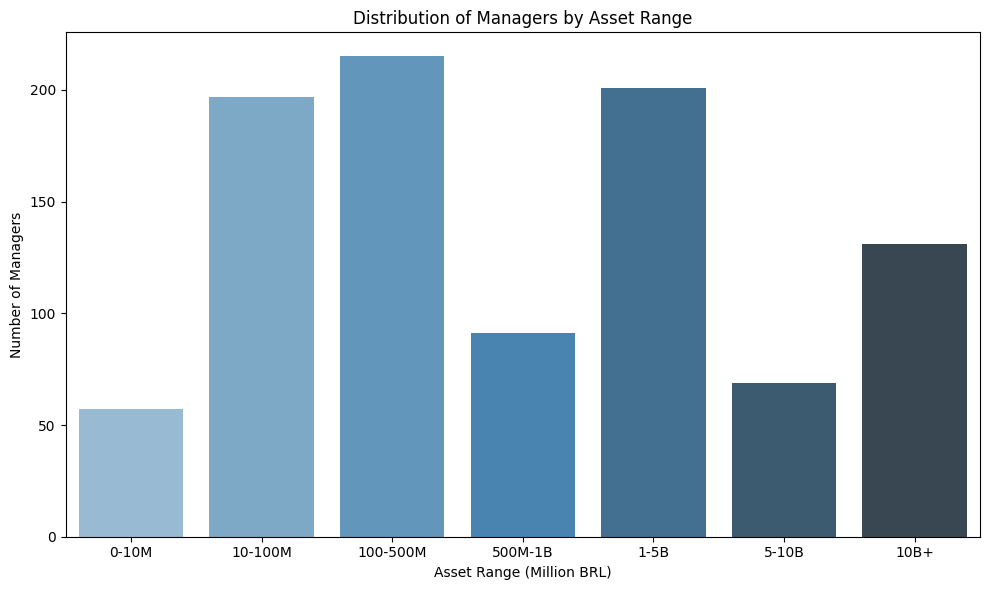

In [6]:
query_rank_gestora_por_patrimonio = text("""SELECT
    rf.gestor,
    SUM(id.vl_patrim_liq) AS patrimonio_sobre_gestao
FROM
    registro_fundo rf
JOIN (
    SELECT
        cnpj_fundo_classe,
        MAX(dt_comptc) AS max_dt
    FROM
        informacao_diaria
    GROUP BY
        cnpj_fundo_classe, id_subclasse, tp_fundo_classe
) latest ON rf.cnpj_fundo = latest.cnpj_fundo_classe
JOIN informacao_diaria id
    ON id.cnpj_fundo_classe = latest.cnpj_fundo_classe
    AND id.dt_comptc = latest.max_dt
WHERE
    rf.gestor IS NOT NULL
    AND rf.situacao != 'Cancelado'
GROUP BY
    rf.gestor
ORDER BY
    patrimonio_sobre_gestao DESC;""")

df = pd.DataFrame.from_records(run_query(query_rank_gestora_por_patrimonio))
df = df[df['patrimonio_sobre_gestao'] > 0]
def distribuicao_gestor_patrimonio():
    df['patrimonio_milhao'] = df['patrimonio_sobre_gestao'] / 1_000_000

    # Define bins (adjust as needed)
    bins = [0, 10, 100, 500, 1000, 5000, 10000, df['patrimonio_milhao'].max()]
    labels = ['0-10M', '10-100M', '100-500M', '500M-1B', '1-5B', '5-10B', '10B+']
    df['faixa_patrimonio'] = pd.cut(df['patrimonio_milhao'], bins=bins, labels=labels, right=False)

    # Count managers per bin
    count_per_bin = df['faixa_patrimonio'].value_counts().sort_index()

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x=count_per_bin.index,
        y=count_per_bin.values,
        hue=count_per_bin.index,      # Assign x to hue
        legend=False,                 # Hide legend
        palette='Blues_d'
    )
    plt.xlabel('Asset Range (Million BRL)')
    plt.ylabel('Number of Managers')
    plt.title('Distribution of Managers by Asset Range')
    plt.tight_layout()
    plt.show()
distribuicao_gestor_patrimonio()

In [7]:
query_acoes = text("SELECT * FROM public.composicao_carteira_demais_codificados where tp_aplic = 'Ações' order by vl_merc_pos_final desc")
r = run_query(query_acoes)

In [9]:
df_composicao_acao = pd.DataFrame.from_records(r)

In [13]:
df_composicao_acao.columns

Index(['cd_ativo', 'cd_isin', 'cnpj_fundo_classe', 'denom_social', 'ds_ativo',
       'dt_comptc', 'dt_confid_aplic', 'dt_fim_vigencia', 'dt_ini_vigencia',
       'emissor_ligado', 'qt_aquis_negoc', 'qt_pos_final', 'qt_venda_negoc',
       'tp_aplic', 'tp_ativo', 'tp_fundo_classe', 'tp_negoc', 'vl_aquis_negoc',
       'vl_custo_pos_final', 'vl_merc_pos_final', 'vl_venda_negoc'],
      dtype='object')